In [26]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [27]:
# Paramètres
nx, ny = 100, 50 # Mise à jour des valeurs de nx et ny
Lx, Ly = 10, 5   # Mise à jour des valeurs de Lx et Ly
nt = 10000
dt = 50
dx = Lx/(nx-1)
dy = Ly/(ny-1)
h = 10
T0, T1, Ta = 273.15, 373.15, 293.15  #Températures en Kelvin (initiale, au bord, et ambiante)
k = 380.0  # Conductivité thermique du cuivre en W/(m·K)
rho = 8960.0  # Densité du cuivre en kg/m³
cp = 385.0  # Capacité thermique du cuivre en J/(kg·K)
alpha = k / (rho * cp)  # Diffusivité thermique du cuivre en m²/s

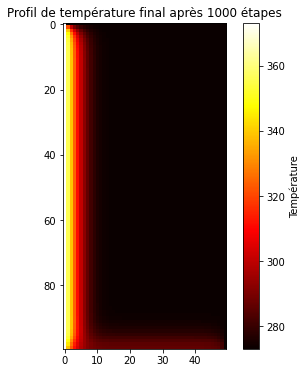

In [28]:
# Definition of functions
def equation(x, L, h, l):
    return x * np.tan(L * x) - h / l

def find_first_n_solutions(L, h, l, n):
    solutions = []
    guess = 0.1
    while len(solutions) < n:
        solution = fsolve(equation, guess, args=(L, h, l))
        solution = solution[0]  # Convertir la solution en un nombre réel
        if not any(abs(sol - solution) < 1e-7 for sol in solutions):  # Vérifier si la solution est déjà dans la liste
            solutions.append(solution)
        guess += 0.1  # Augmenter la supposition initiale pour la prochaine solution
    return solutions

def serie(Lx, Ly, h, l, x, y, n):
    sum = 0
    for k in range(0, n+1):
        a = liste_solutions[k]
        x_k = (np.cos(a*x)*np.cosh(a*(Ly-y)))/(((a**2+(h/l)**2)*Lx+h/l)*np.cos(a*Lx)*np.cosh(a*Ly))
        # print(x_k)
        sum += x_k
    # print("sum =", sum)
    return sum

def generate_analytical_profile(nx, ny, Lx, Ly, T1, Ta, h, k, n):
    # Définir les pas en x et y
    dx = 0.15*Lx/(nx-1)
    dy = 0.15*Ly/(ny-1)

    # Créer des grilles de points x et y
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)

    # Initialiser le profil analytique
    T_analytical = np.zeros((nx, ny))

    # Calculer le profil analytique en utilisant une formule spécifique
    for i in range(nx):
        for j in range(ny):
            x = i/nx
            y = j/ny
            # Mettre en œuvre la formule analytique en fonction de x, y et d'autres paramètres
            sum = serie(Lx, Ly, h, k, x, y, n)
            T_analytical[i, j] = (Ta + 2*(T1-Ta)*sum*10/401)

    # Tracer le profil analytique
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(T_analytical, cmap='hot', interpolation='nearest')
    colorbar = fig.colorbar(im, ax=ax)
    colorbar.set_label('Température')
    # plt.imshow(T_analytical, cmap='hot', origin='lower', extent=[0, Lx, 0, Ly])
    # plt.colorbar(label='Température')
    # plt.xlabel('x')
    # plt.ylabel('y')
    # plt.title('Profil de température analytique')
    # plt.gca().set_ylim(50, 0)
    plt.show()
    return T_analytical

# Méthode TDMA
def TDMA(a, b, c, d):
    n = len(d)
    w = np.zeros(n-1,float)
    g = np.zeros(n, float)
    p = np.zeros(n,float)

    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

# Méthode ADI
def ADI_method(T, nx, ny, nt, dt, dx, dy, alpha, T1, h, Ta, k):
    it = 0
    while it < nt:
        T_old = T.copy()

        # Étape 1 : résoudre dans la direction x
        for j in range(1, ny-1):
            a = np.full(nx-1, -alpha*dt/(2*dx**2))
            b = np.full(nx-1, 1 + alpha*dt/(dx**2))
            c = np.full(nx-1, -alpha*dt/(2*dx**2))
            d = T_old[1:-1, j] + alpha*dt/(2*dy**2) * (T_old[1:-1, j+1] - 2*T_old[1:-1, j] + T_old[1:-1, j-1])

            # Appliquer les conditions aux limites
            d[0] += alpha*dt/(2*dx**2) * T_old[0, j]
            d[-1] += alpha*dt/(2*dx**2) * (2*dx*h*(Ta-T_old[-1, j])/(2*dx*h+alpha) + T_old[-2, j])

            T[1:-1, j] = TDMA(a, b, c, d)

        # Appliquer la condition de conducto-convection à x = Lx
        T[-1, :] = (2*dx*h*Ta + k*T[-2, :]) / (2*dx*h + k)

        T_old = T.copy()

        # Étape 2 : résoudre dans la direction y
        for i in range(1, nx-1):
            a = np.full(ny-1, -alpha*dt/(2*dy**2))
            b = np.full(ny-1, 1 + alpha*dt/(dy**2))
            c = np.full(ny-1, -alpha*dt/(2*dy**2))
            d = T_old[i, 1:-1] + alpha*dt/(2*dx**2) * (T_old[i+1, 1:-1] - 2*T_old[i, 1:-1] + T_old[i-1, 1:-1])

            # Appliquer les conditions aux limites
            d[0] += alpha*dt/(2*dy**2) * T1
            d[-1] += alpha*dt/(2*dy**2) * T_old[i, -2]

            T[i, 1:-1] = TDMA(a, b, c, d)
        it += dt

    return T

# Solution numérique

# # # Initialiser le profil de température à T0
T = np.full((nx, ny), T0)

# Appliquer les conditions aux limites initiales
T[:, 0] = T1
T[0, :] = T[1, :]
T[-1, :] = T[-2, :]
T[:, -1] = (2*dy*h*Ta + k*T[:, -2]) / (2*dy*h + k)

# Exécuter la méthode ADI
T = ADI_method(T, nx, ny, nt, dt, dx, dy, alpha, T1, h, Ta, k)

# Tracer le profil de température final
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(T, cmap='hot', interpolation='nearest')
colorbar = fig.colorbar(im, ax=ax)
colorbar.set_label('Température')
ax.set_title(f"Profil de température final après {nt} étapes")
plt.show()

#print(T)

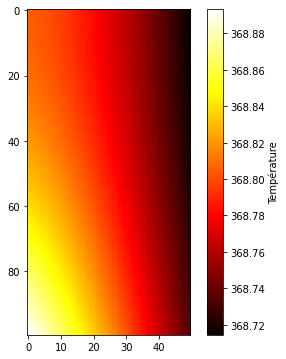

In [29]:
# Solution analytique
n_solutions = 11
liste_solutions = find_first_n_solutions(Lx, h, k, n_solutions)
# print(liste_solutions)

T_analytical = generate_analytical_profile(nx, ny, Lx, Ly, T1, Ta, h, k, 3)

[[-4.25641524 95.74089667 95.73817239 ... 95.59150218 95.58794966
  95.47755533]
 [-4.2580182  47.48718343 68.58735344 ... 95.56995587 95.55257117
  95.47721674]
 [-4.25961166 29.12825559 51.65437286 ... 95.55416476 95.53195068
  95.47687916]
 ...
 [-4.34477105 19.97426129 37.85150841 ... 87.87501929 89.66978218
  95.45761688]
 [-4.34480091 24.475078   42.43650612 ... 85.71594812 87.38507692
  95.45760977]
 [-3.92175427 30.1809092  46.23362449 ... 84.62856401 86.97593547
  95.35240823]]


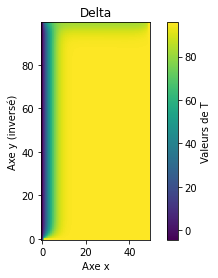

In [30]:
# Comparaison
T_inverse = np.flipud(T_analytical)
Delta = T_inverse - T
print(Delta)

plt.imshow(Delta, origin='lower')
plt.colorbar(label='Valeurs de T')
plt.xlabel('Axe x')
plt.ylabel('Axe y (inversé)')
plt.title('Delta')
plt.show()